<a href="https://colab.research.google.com/github/gshah8/UCF/blob/master/Machine_Learning/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW 2

The goal of this homework is to create a convolutional neural network for the CIFAR10 data set. 
See [this colab notebook](https://colab.research.google.com/drive/1LZZviWOzvchcXRdZi2IBx3KOpQOzLalf) how to load the CIFAR data in Keras.

You should not use any pretrained convnets that come with Keras. You have to create and train your own convnets with Keras from scratch.

## Simple hold-out validation

Make sure that the data is divided into: 

- training set (80%)
- validation set (20%)
- test set. 

Use the training set to train your neural networks. Evaluate their performance on the validation data set. 

After trying several different architectures, choose the one that performs
best of the validation set. Try at least four different architectures by using data augmentation, using dropout, varying the number of layers, the number of filters, etc.

Train this final architecture on the data from the training set and validation set and evaluate its performance on 
the test set.

## k-fold validation

Reevaluate your best architecture using k-fold validation with k=5, that is, the size of the validation fold is 20%. Does the accuracy/loss obtain by k-fold validation differ from the accuracy/loss obtain by simple hold-out validation.

### Loading the CIFAR10 data set



In [0]:
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator


(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

### Exploring the format of the CIFAR10 data set

In [0]:
train_images.shape

(50000, 32, 32, 3)

In [0]:
train_images.ndim

4

In [0]:
train_labels.shape

(50000, 1)

In [0]:
train_labels.ndim

2

###Using Simple Hold Validation for the models below

In [5]:
#divide training data into training and validation data
rand_idx = np.random.permutation(len(train_images))
val_idx = rand_idx[0:2000]
train_idx = rand_idx[2000:]

train_images_new, train_labels_new = train_images[train_idx] , train_labels[train_idx]
val_images, val_labels = train_images[val_idx] , train_labels[val_idx]

#normalize training and validation data
train_images_norm = train_images_new/255.0
val_images_norm = val_images/255.0

#train_images_norm.shape
#train_images_norm.shape
train_labels_new[0]

array([6], dtype=uint8)

###Preprocess test data

In [6]:
from keras.utils import np_utils
#train_images_norm = train_images/255
test_images_norm = test_images/255.0

#one-hot encoding
train_labels_norm = to_categorical(train_labels_new)
val_labels_norm = to_categorical(val_labels)
test_labels_norm = to_categorical(test_labels)

train_labels_norm[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

###Build a basic model (without Data Augmentation and Dropout)

In [0]:

# set up the layers

model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_84 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1024)              0         
__________

###Compile the Model

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

###Train the Model

In [0]:
#epochs = 20
#history = model.fit(train_images_norm, 
#                      train_labels_norm, 
#                      epochs=epochs,  
#                      validation_data=(val_images_norm, val_labels))

#epochs = 20
#history = model.fit(train_images_norm, 
#                      train_labels_norm, 
#                      epochs=epochs,  
#                      validation_data=(val_images_norm, val_labels))



epochs = 20
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Train on 48000 samples, validate on 2000 samples
Epoch 1/20
48000/48000 [==============================] - 12s 243us/step - loss: 1.5230 - acc: 0.4483 - val_loss: 1.2299 - val_acc: 0.5475
Epoch 2/20
48000/48000 [==============================] - 11s 219us/step - loss: 1.1205 - acc: 0.6035 - val_loss: 1.0132 - val_acc: 0.6355
Epoch 3/20
48000/48000 [==============================] - 10s 218us/step - loss: 0.9532 - acc: 0.6671 - val_loss: 0.9297 - val_acc: 0.6585
Epoch 4/20
48000/48000 [==============================] - 10s 215us/step - loss: 0.8555 - acc: 0.7036 - val_loss: 0.9094 - val_acc: 0.6795
Epoch 5/20
48000/48000 [==============================] - 10s 217us/step - loss: 0.7809 - acc: 0.7288 - val_loss: 0.8670 - val_acc: 0.6995
Epoch 6/20
48000/48000 [==============================] - 10s 217us/step - loss: 0.7153 - acc: 0.7494 - val_loss: 0.8177 - val_acc: 0.7240
Epoch 7/20
48000/48000 [==============================] - 10s 215us/step - loss: 0.6592 - acc: 0.7708 - val_loss: 0.8

We can observe that the model is clearly overfitted since the training accuracy is increasing as we increase the number of epochs but the validation accuracy is not increasing.

Now, we will try to improve the model by using the four following architectures:
1. increasing the number of convolutional layers
2. Adding more filters
3. Data Augmentation
4. Dropout

We will add the above mentioned architectures one by one and observe the training and validation accuracy.
In the end, as a final check, we will run the model for test data.

###1. Increase the number of convolutional layers

In [0]:

# set up the layers

model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_79 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 4, 4, 128)         147584    
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
epochs = 40
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Train on 48000 samples, validate on 2000 samples
Epoch 1/40
48000/48000 [==============================] - 16s 334us/step - loss: 1.5184 - acc: 0.4419 - val_loss: 1.1870 - val_acc: 0.5580
Epoch 2/40
48000/48000 [==============================] - 14s 300us/step - loss: 1.0602 - acc: 0.6225 - val_loss: 0.9539 - val_acc: 0.6490
Epoch 3/40
48000/48000 [==============================] - 14s 299us/step - loss: 0.8468 - acc: 0.7018 - val_loss: 0.8437 - val_acc: 0.7095
Epoch 4/40
48000/48000 [==============================] - 14s 298us/step - loss: 0.7225 - acc: 0.7469 - val_loss: 0.9177 - val_acc: 0.6865
Epoch 5/40
48000/48000 [==============================] - 14s 300us/step - loss: 0.6219 - acc: 0.7812 - val_loss: 0.8103 - val_acc: 0.7235
Epoch 6/40
48000/48000 [==============================] - 14s 299us/step - loss: 0.5327 - acc: 0.8119 - val_loss: 0.7843 - val_acc: 0.7415
Epoch 7/40
48000/48000 [==============================] - 14s 301us/step - loss: 0.4543 - acc: 0.8398 - val_loss: 0.7

Adding another layer doesn't increase validation accuracy.There is even more overfitting since the training accuracy is around 98% for the 40th epoch whereas it is just around 75% for validation data.

Therefore, now we are going to include regularization, data augmentation and dropout one by one to the existing model with 4 layers in order to see how to validation accuracy improves and overfitting is minimized.

###Add Regularization

In [0]:
from keras import regularizers
# set up the layers
weight_decay = 1e-4
model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.MaxPooling2D((2, 2)))
#4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_93 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_94 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 4, 4, 128)         147584    
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
epochs = 40
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Train on 48000 samples, validate on 2000 samples
Epoch 1/40
48000/48000 [==============================] - 16s 336us/step - loss: 1.5280 - acc: 0.4500 - val_loss: 1.2838 - val_acc: 0.5445
Epoch 2/40
48000/48000 [==============================] - 15s 306us/step - loss: 1.1128 - acc: 0.6173 - val_loss: 1.0010 - val_acc: 0.6530
Epoch 3/40
48000/48000 [==============================] - 15s 308us/step - loss: 0.9257 - acc: 0.6899 - val_loss: 0.8848 - val_acc: 0.7070
Epoch 4/40
48000/48000 [==============================] - 15s 306us/step - loss: 0.8100 - acc: 0.7372 - val_loss: 0.8429 - val_acc: 0.7310
Epoch 5/40
48000/48000 [==============================] - 15s 306us/step - loss: 0.7256 - acc: 0.7685 - val_loss: 0.8397 - val_acc: 0.7220
Epoch 6/40
48000/48000 [==============================] - 15s 307us/step - loss: 0.6567 - acc: 0.7932 - val_loss: 0.7882 - val_acc: 0.7525
Epoch 7/40
48000/48000 [==============================] - 15s 306us/step - loss: 0.6021 - acc: 0.8151 - val_loss: 0.8

Adding regulaizer reduces overfitting just by a little bit (1%). We will continue adding more architectures

###3. Add Batch Normalization

In [22]:
#from keras import regularizers
# set up the layers
weight_decay = 1e-4
model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         73856     
__________

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [7]:
epochs = 40
history = model.fit(train_images_norm, 
                      train_labels_norm, 
                      epochs=epochs, 
                      batch_size=64, 
                      validation_data=(val_images_norm, val_labels_norm))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 2000 samples
Epoch 1/40
48000/48000 [==============================] - 25s 520us/step - loss: 1.2435 - acc: 0.5696 - val_loss: 1.1114 - val_acc: 0.6220
Epoch 2/40
48000/48000 [==============================] - 21s 445us/step - loss: 0.8692 - acc: 0.7105 - val_loss: 0.8628 - val_acc: 0.7065
Epoch 3/40
48000/48000 [==============================] - 21s 442us/step - loss: 0.7144 - acc: 0.7675 - val_loss: 1.0025 - val_acc: 0.6850
Epoch 4/40
48000/48000 [==============================] - 21s 447us/step - loss: 0.6043 - acc: 0.8079 - val_loss: 0.9745 - val_acc: 0.6980
Epoch 5/40
48000/48000 [==============================] - 21s 448us/step - loss: 0.5184 - acc: 0.8432 - val_loss: 0.9533 - val_acc: 0.7105
Epoch 6/40
48000/48000 [==============================] - 21s 442us/step - loss: 0.4445 - acc: 0.8731 - val_loss: 0.8958 - val_acc: 0.7540
Epoch 7/40
48000/48000 [==============================] - 21s 445us/s

###4. Add Data Augmentation

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [25]:
epochs = 40
datagen = ImageDataGenerator(
    #rescale=1./255,  #our image is already normalized so we dont need this
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images_new)

history = model.fit_generator(datagen.flow(train_images_norm, train_labels_norm, batch_size=64),
                    steps_per_epoch=int(len(train_images_norm) / 64), epochs=epochs,
                   verbose=1, validation_data=(val_images_norm, val_labels_norm))


Epoch 1/40
750/750 [==============================] - 43s 58ms/step - loss: 1.6629 - acc: 0.4140 - val_loss: 1.3757 - val_acc: 0.5225
Epoch 2/40
750/750 [==============================] - 40s 54ms/step - loss: 1.3775 - acc: 0.5199 - val_loss: 1.1541 - val_acc: 0.6045
Epoch 3/40
750/750 [==============================] - 41s 55ms/step - loss: 1.2584 - acc: 0.5665 - val_loss: 1.2307 - val_acc: 0.5925
Epoch 4/40
750/750 [==============================] - 41s 55ms/step - loss: 1.1794 - acc: 0.6007 - val_loss: 1.0863 - val_acc: 0.6360
Epoch 5/40
750/750 [==============================] - 41s 55ms/step - loss: 1.1298 - acc: 0.6221 - val_loss: 1.3692 - val_acc: 0.5350
Epoch 6/40
750/750 [==============================] - 41s 55ms/step - loss: 1.0876 - acc: 0.6432 - val_loss: 1.0769 - val_acc: 0.6470
Epoch 7/40
750/750 [==============================] - 41s 55ms/step - loss: 1.0661 - acc: 0.6509 - val_loss: 1.1228 - val_acc: 0.6455
Epoch 8/40
750/750 [==============================] - 42s 56ms

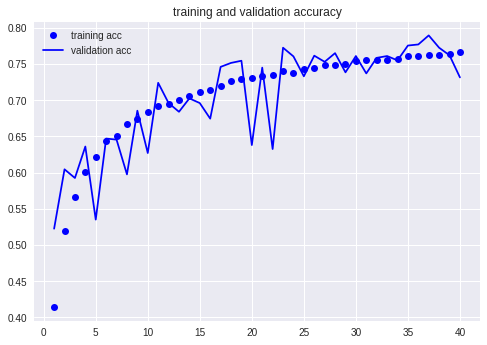

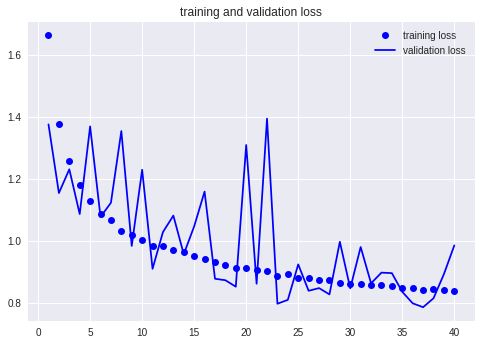

In [26]:
#print(epochs)
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

###5. Add dropout

In [27]:
#from keras import regularizers
# set up the layers
weight_decay = 1e-4
model = models.Sequential()
#conv layers   
#1
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay), input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#2
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
#3
model.add(layers.Conv2D(128, (3, 3), activation='relu',padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
#4
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding = 'same', kernel_regularizer= regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

#dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

NameError: ignored

In [0]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [0]:
epochs = 40
datagen = ImageDataGenerator(
    #rescale=1./255,  #our image is already normalized so we dont need this
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(train_images_new)

history = model.fit_generator(datagen.flow(train_images_norm, train_labels_norm, batch_size=64),
                    steps_per_epoch=int(len(train_images_norm) / 64), epochs=epochs,
                   verbose=1, validation_data=(val_images_norm, val_labels_norm))
